## Import Packages

In [23]:
import keras

In [24]:
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Concatenate
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.misc import toimage
import time
import math


## Plotting Functions

In [27]:
## Plotting Functionsdef plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [28]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

## Hyperparameters

In [29]:
# Hyperparameters
batch_size = 256
num_classes = 10
epochs = 250
l = 15
nb_filter = 24
compression = 0.46
dropout_rate = 0.0
growth_rate = 12

## LR Schedule Function

In [30]:
def lr_schedule(epoch):
    #lrate = 0.001
    lrate = 0.01
    if epoch > 75:
        #lrate = 0.0005
        lrate = 0.001
    elif epoch > 150:
        #lrate = 0.0003
        lrate = 0.001
    return lrate

## LR Step Decay function

In [55]:
# learning rate schedule
def step_decay(epoch):
  initial_lrate = 0.1
  drop = 0.5
  epochs_drop = 10.0
  lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
  lrate = 1e-6
  return lrate

## Load and Normalize Data

In [32]:
# Load CIFAR10 Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

# convert to one hot encoding 
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_test /= 255.0

## Define Densenet Model functions

In [33]:
# Dense Block
def add_denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression, growth_rate, nb_filter
    temp = input
    for _ in range(l):
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
        Conv2D_3_3 = Conv2D(growth_rate, (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
          Conv2D_3_3 = Dropout(dropout_rate)(Conv2D_3_3)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        nb_filter += growth_rate
        temp = concat
        
    return temp

In [34]:
def add_transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = Conv2D(int(num_filter * compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
      Conv2D_BottleNeck = Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

In [35]:
def output_layer(input):
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    #AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    GlobalAvg = GlobalAveragePooling2D()(relu)
    #flat = Flatten()(AvgPooling)
    output = Dense(num_classes, activation='softmax')(GlobalAvg)
    
    return output

## Create Densenet Model

In [36]:
#num_filter = 24
#dropout_rate = 0.2
#l = 12
input = Input(shape=(img_height, img_width, channel,))
First_Conv2D = Conv2D(nb_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = add_denseblock(First_Conv2D, nb_filter, dropout_rate)
First_Transition = add_transition(First_Block, nb_filter, dropout_rate)

Second_Block = add_denseblock(First_Transition, nb_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, nb_filter, dropout_rate)

Third_Block = add_denseblock(Second_Transition, nb_filter, dropout_rate)
#Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

output = output_layer(Third_Block)


In [37]:
model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 32, 32, 24)   648         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_49 (BatchNo (None, 32, 32, 24)   96          conv2d_49[0][0]                  
__________________________________________________________________________________________________
activation_49 (Activation)      (None, 32, 32, 24)   0           batch_normalization_49[0][0]     
__________________________________________________________________________________________________
conv2d_50 

## Define Data Augmentation

In [39]:
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

## Initialize SGD

In [40]:
#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
sgd = SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=True)

In [41]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

## Define Early Stopping Callback

In [43]:
earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0000, patience=6, \
                          verbose=1, mode='auto')

## Define LR Reducer Callback

In [44]:
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.25,
                              patience=4, min_lr=0.00001)

## Define checkpoint and callbacks

In [45]:
# checkpoint
filepath="./weights/weights_AWS.best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#clr_triangular = CyclicLR(mode='triangular2')
#clr_triangular = CyclicLR(base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular2')
#callbacks_list = [checkpoint]
#callbacks_list = [checkpoint, LearningRateScheduler(step_decay), earlystop]
callbacks_list = [checkpoint, reduce_lr, earlystop]



## Training - Epochs 1 to 51 (max val_acc: 91.02%)

In [47]:
start = time.time()
model_info = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=epochs,\
                    verbose=1, validation_data=(x_test,y_test),\
                    callbacks=callbacks_list) 
end = time.time()


Epoch 1/250
195/195 [==============================] - 318s 2s/step - loss: 1.4020 - acc: 0.4893 - val_loss: 3.6022 - val_acc: 0.3406

Epoch 00001: val_acc improved from -inf to 0.34060, saving model to ./weights/weights_AWS.best.h5
Epoch 2/250
195/195 [==============================] - 262s 1s/step - loss: 0.9368 - acc: 0.6662 - val_loss: 1.2172 - val_acc: 0.5943

Epoch 00002: val_acc improved from 0.34060 to 0.59430, saving model to ./weights/weights_AWS.best.h5
Epoch 3/250
195/195 [==============================] - 259s 1s/step - loss: 0.7428 - acc: 0.7412 - val_loss: 1.0892 - val_acc: 0.6393

Epoch 00003: val_acc improved from 0.59430 to 0.63930, saving model to ./weights/weights_AWS.best.h5
Epoch 4/250
195/195 [==============================] - 259s 1s/step - loss: 0.6392 - acc: 0.7788 - val_loss: 1.2402 - val_acc: 0.6329

Epoch 00004: val_acc did not improve from 0.63930
Epoch 5/250
195/195 [==============================] - 259s 1s/step - loss: 0.5656 - acc: 0.8049 - val_loss: 1


Epoch 00041: val_acc improved from 0.90980 to 0.91020, saving model to ./weights/weights_AWS.best.h5
Epoch 42/250
195/195 [==============================] - 259s 1s/step - loss: 0.0769 - acc: 0.9735 - val_loss: 0.3201 - val_acc: 0.9075

Epoch 00042: val_acc did not improve from 0.91020
Epoch 43/250
195/195 [==============================] - 260s 1s/step - loss: 0.0806 - acc: 0.9724 - val_loss: 0.3229 - val_acc: 0.9073

Epoch 00043: val_acc did not improve from 0.91020
Epoch 44/250
195/195 [==============================] - 259s 1s/step - loss: 0.0768 - acc: 0.9737 - val_loss: 0.3184 - val_acc: 0.9066

Epoch 00044: val_acc did not improve from 0.91020
Epoch 45/250
195/195 [==============================] - 259s 1s/step - loss: 0.0778 - acc: 0.9740 - val_loss: 0.3220 - val_acc: 0.9061

Epoch 00045: val_acc did not improve from 0.91020
Epoch 46/250
195/195 [==============================] - 259s 1s/step - loss: 0.0750 - acc: 0.9741 - val_loss: 0.3190 - val_acc: 0.9085

Epoch 00046: val_a

## Training - Epochs 51 to 78 (max val_acc: 92.44%)

In [58]:
start = time.time()
model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test), 
                    callbacks=callbacks_list)
end = time.time()


Train on 50000 samples, validate on 10000 samples
Epoch 1/250
50000/50000 [==============================] - 259s 5ms/step - loss: 0.0435 - acc: 0.9873 - val_loss: 0.2525 - val_acc: 0.9229

Epoch 00001: val_acc improved from 0.91020 to 0.92290, saving model to ./weights/weights_AWS.best.h5
Epoch 2/250
50000/50000 [==============================] - 261s 5ms/step - loss: 0.0435 - acc: 0.9873 - val_loss: 0.2494 - val_acc: 0.9238

Epoch 00002: val_acc improved from 0.92290 to 0.92380, saving model to ./weights/weights_AWS.best.h5
Epoch 3/250
50000/50000 [==============================] - 261s 5ms/step - loss: 0.0429 - acc: 0.9873 - val_loss: 0.2489 - val_acc: 0.9242

Epoch 00003: val_acc improved from 0.92380 to 0.92420, saving model to ./weights/weights_AWS.best.h5
Epoch 4/250
50000/50000 [==============================] - 261s 5ms/step - loss: 0.0433 - acc: 0.9872 - val_loss: 0.2485 - val_acc: 0.9238

Epoch 00004: val_acc did not improve from 0.92420
Epoch 5/250
50000/50000 [============

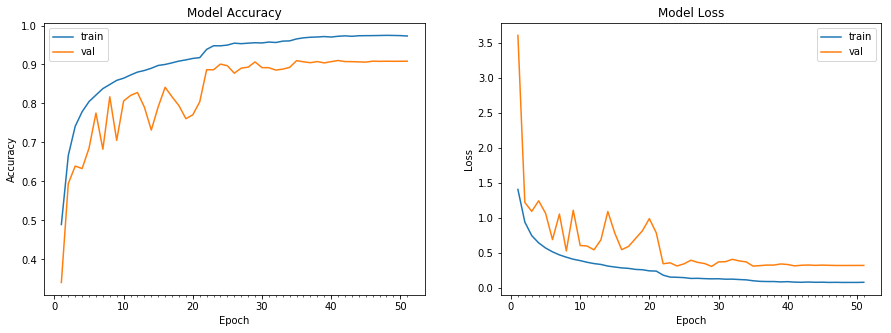

Model took 13308.52 seconds to train
Accuracy on test data is: 90.85


In [48]:
# plot model history
plot_model_history(model_info)
print("Model took %0.2f seconds to train" % (end - start))
# compute test accuracy
print("Accuracy on test data is: %0.2f" % accuracy(x_test, y_test, model))

In [49]:
# Test the model
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 19s 2ms/step
Test loss: 0.31753011630177497
Test accuracy: 0.9085
